In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from os import walk
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


## Task 1

- Download data one or several posts from source Irpin university street 

In [2]:
file_path = "./data/saveecobot_13848.csv"

In [3]:
def reading_text(file_path):
    headers = ['device_id', 'phenomenon', 'value', 'logged_at', 'value_text']

    df = pd.read_csv(file_path, on_bad_lines='skip')
    
    # df.head()

    df = df.drop(columns='value_text').dropna(axis=0)
   
    return(df)

In [4]:
df = reading_text(file_path)
df

/var/folders/7y/jzj3rvbx3875_q5lqczlj3x00000gn/T/ipykernel_6579/2728567861.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, on_bad_lines='skip')


,device_id,phenomenon,value,logged_at
0,13848,pm1,1.640740e+01,2020-11-01 17:36:15
1,13848,pm25,2.655560e+01,2020-11-01 17:36:15
2,13848,pm10,3.044440e+01,2020-11-01 17:36:15
3,13848,temperature,7.879100e+00,2020-11-01 17:36:15
4,13848,humidity,1.000000e+02,2020-11-01 17:36:15
...,...,...,...,...
12236248,13848,pm25,1.539000e+00,2025-09-21 09:24:00
12236249,13848,pm10,2.231000e+00,2025-09-21 09:24:00
12236250,13848,temperature,1.888100e+01,2025-09-21 09:24:00
12236251,13848,humidity,1.000000e+02,2025-09-21 09:24:00


##  Task 2



-  Analyze the downloaded dataset, prepare it for use

In [5]:
df.isnull().sum()

device_id     0
phenomenon    0
value         0
logged_at     0
dtype: int64

In [6]:
df.dtypes

device_id      object
phenomenon     object
value         float64
logged_at      object
dtype: object

In [7]:
df['logged_at'] = pd.to_datetime(df['logged_at'], format = "%Y-%m-%d %H:%M:%S")

convert_dict = {'device_id' : int}

df['value'] = pd.to_numeric(df['value'], errors='coerce')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

df = df.astype(convert_dict)

In [8]:
df.dtypes

device_id              int64
phenomenon            object
value                float64
logged_at     datetime64[ns]
dtype: object

In [9]:
df['value']

0               16.4074
1               26.5556
2               30.4444
3                7.8791
4              100.0000
               ...     
12236248         1.5390
12236249         2.2310
12236250        18.8810
12236251       100.0000
12236252   1009718.5000
Name: value, Length: 12236252, dtype: float64

In [10]:
unique_values = df['phenomenon'].unique()
print(f'Unique values in: {unique_values}')

Unique values in: ['pm1' 'pm25' 'pm10' 'temperature' 'humidity' 'pressure_pa']


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12236252 entries, 0 to 12236252
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   device_id   int64         
 1   phenomenon  object        
 2   value       float64       
 3   logged_at   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 466.8+ MB


## Task 3

- Find possible dependencies between air pollutants (does PM2.5 depend on carbon monoxide, etc.).
- Do this using regression analysis.
- Obtain dependency indicators (or show that such dependencies do not exist).

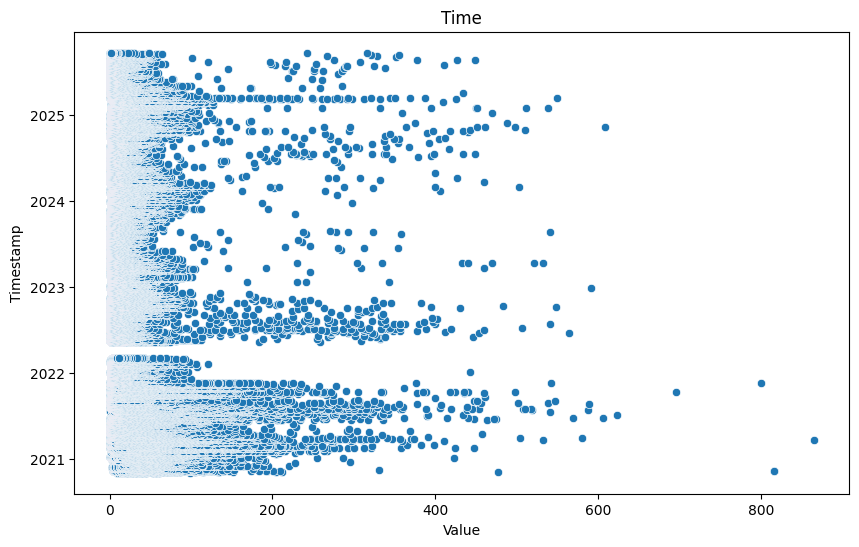

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df[df['phenomenon'] == 'pm25'], 
                 x='value', 
                 y='logged_at')
plt.title('Time')
plt.xlabel('Value')
plt.ylabel('Timestamp')
plt.show()

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'humidity'),
  Text(0, 1.5, 'pm1'),
  Text(0, 2.5, 'pm10'),
  Text(0, 3.5, 'pm25'),
  Text(0, 4.5, 'pressure_pa'),
  Text(0, 5.5, 'temperature')])

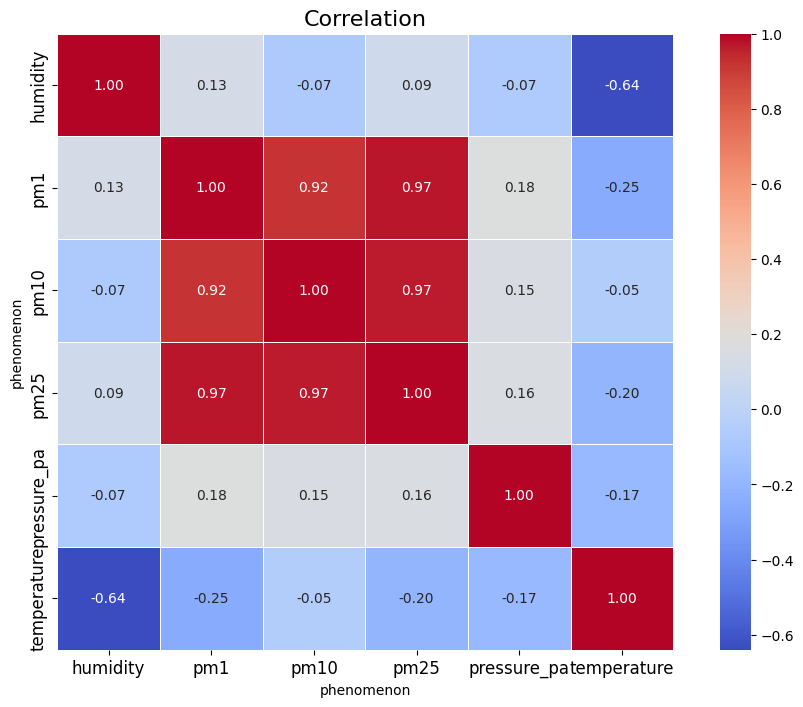

In [13]:
pivot_df = df.pivot_table(index='logged_at', columns='phenomenon', values='value')
correlation_matrix = pivot_df.corr()
plt.figure(figsize=(12, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',  
    linewidths=.5,  
    square=True  
)

plt.title('Correlation', fontsize=16)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)

the best correlation is  pm1-pm25, pm10-pm25, pm1-pm10

## Task 4

In [14]:
pivot_df.corr()

phenomenon,humidity,pm1,pm10,pm25,pressure_pa,temperature
phenomenon,,,,,,
humidity,1.0000,0.1257,-0.0743,0.0907,-0.0654,-0.6400
pm1,0.1257,1.0000,0.9203,0.9690,0.1779,-0.2530
pm10,-0.0743,0.9203,1.0000,0.9668,0.1540,-0.0496
pm25,0.0907,0.9690,0.9668,1.0000,0.1586,-0.2007
pressure_pa,-0.0654,0.1779,0.1540,0.1586,1.0000,-0.1729
temperature,-0.6400,-0.2530,-0.0496,-0.2007,-0.1729,1.0000


In [15]:
X = pivot_df[['pm1', 'temperature']]
y = pivot_df['pm25']

X = sm.add_constant(X)  
model = sm.OLS(y, X, missing='drop').fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 1.627e+07
Date:                Mon, 22 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:03:04   Log-Likelihood:            -5.3893e+06
No. Observations:             2039052   AIC:                         1.078e+07
Df Residuals:                 2039049   BIC:                         1.078e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.9161      0.004   -434.964      

In [16]:
predictions = model.predict(X)

print("RMSE:", np.sqrt(np.mean((predictions - y) ** 2)))

RMSE: 3.401100836152008


R-squared:                       0.941 is really strong reltionship between the prediction and real data

In [17]:
df['hour'] = df['logged_at'].dt.hour

df_pollutant = df[df['phenomenon'] == 'pm10']

X = df_pollutant[['hour']].copy()  
y = df_pollutant['value'].copy()  

X.loc[:, 'hour'] = X['hour'].fillna(X['hour'].mean())
y = y.fillna(y.mean())

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [19]:
print("R^2:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R^2: 0.00922739284063201
RMSE: 16.339948200917153


An value of 0.0092 suggests that the model has a weak relationship between the hour of the day and the pollution

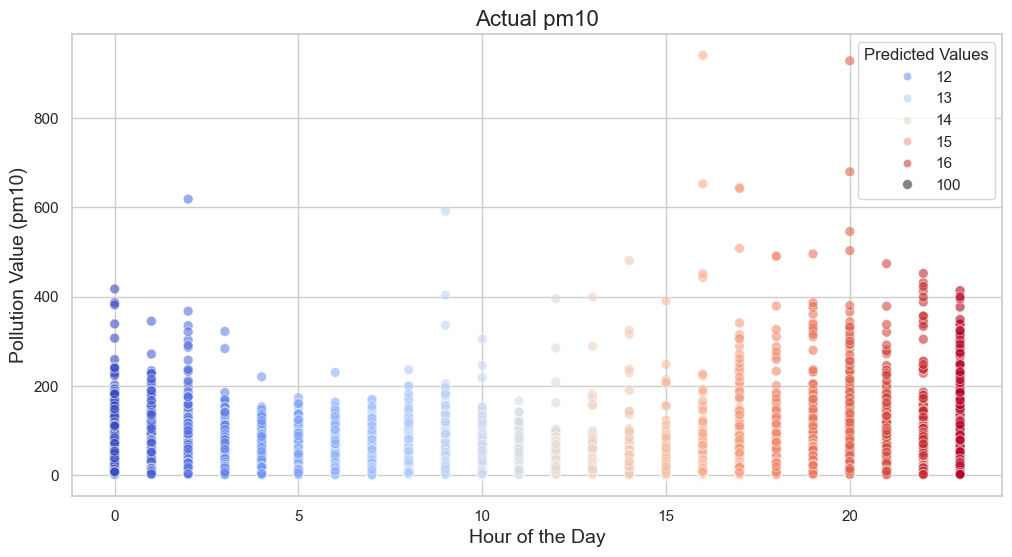

In [20]:
plt.figure(figsize=(12, 6))  
results_df = pd.DataFrame({
    'Hour of day': X_test['hour'],  
    'Actual values': y_test,
    'Predicted values': y_pred
})


sns.set(style="whitegrid")

sns.scatterplot(data=results_df, x='Hour of day', y='Actual values',
                hue='Predicted values', palette='coolwarm', 
                alpha=0.6, size=100, sizes=(50, 200))


plt.title('Actual pm10', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Pollution Value (pm10)', fontsize=14)

plt.legend(title='Predicted Values')

plt.show()